In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import tqdm

import torchvision
import torchvision.transforms as transforms
import random
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
set_seed(14)


In [53]:
# TODO load data
def one_hot(labels, classes):
    return np.eye(classes)[labels]

transform = transforms.Compose(
    [transforms.ToTensor(),
     # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

train_data,train_labels = trainset.train_data, torch.tensor(trainset.train_labels)
train_data = torch.from_numpy(np.expand_dims(train_data, axis=1)).float()[:,0,:,:].cuda()
train_data /= 256
train_labels = torch.from_numpy(one_hot(train_labels,10)).cuda()

validset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

valid_data,valid_labels = validset.test_data, torch.tensor(validset.test_labels)
valid_data = torch.from_numpy(np.expand_dims(valid_data, axis=1)).float()[:,0,:,:].cuda()
valid_data /= 256
valid_labels = torch.from_numpy(one_hot(valid_labels,10)).cuda()


train_dataloader = DataLoader(TensorDataset(train_data, train_labels), batch_size=64, shuffle=True)
test_dataloader = DataLoader(TensorDataset(valid_data, valid_labels), batch_size=64, shuffle=True)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

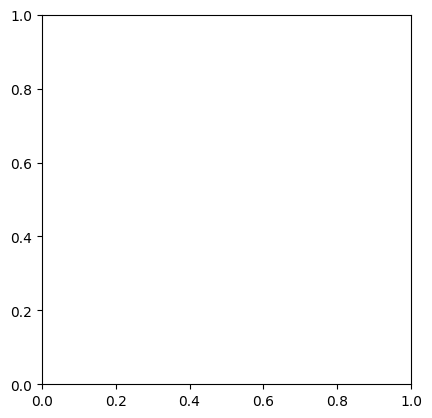

In [54]:
from matplotlib import pyplot as plt

plt.imshow(train_data[0])

In [ ]:
feature_shape = train_data.shape[1]
classes       = 10


def PoissonGen(inp, rescale_fac=2.0):
    rand_inp = torch.rand_like(inp).cuda()
    return torch.mul(torch.le(rand_inp * rescale_fac, torch.abs(inp)).float(), torch.sign(inp))


class Surrogate_BP_Function(torch.autograd.Function):


    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input).cuda()
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input * 0.3 * F.threshold(1.0 - torch.abs(input), 0, 0)
        return grad


class Model(nn.Module):
    def __init__(self, timesteps=20, leak_mem=0.95, img_size=28,  num_cls=10):
        super(Model, self).__init__()

        self.img_size = img_size
        self.num_cls = num_cls
        self.timesteps = timesteps
        self.spike_fn = Surrogate_BP_Function.apply
        self.leak_mem = leak_mem
        self.batch_num = self.timesteps

        print (">>>>>>>>>>>>>>>>>>> VGG 9 >>>>>>>>>>>>>>>>>>>>>>")
        print ("***** time step per batchnorm".format(self.batch_num))
        print (">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")

        affine_flag = True
        bias_flag = False

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bntt1 = nn.ModuleList([nn.BatchNorm2d(64, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bntt2 = nn.ModuleList([nn.BatchNorm2d(64, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.pool1 = nn.AvgPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bntt3 = nn.ModuleList([nn.BatchNorm2d(128, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bntt4 = nn.ModuleList([nn.BatchNorm2d(128, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.pool2 = nn.AvgPool2d(kernel_size=2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bntt5 = nn.ModuleList([nn.BatchNorm2d(256, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bntt6 = nn.ModuleList([nn.BatchNorm2d(256, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bntt7 = nn.ModuleList([nn.BatchNorm2d(256, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.pool3 = nn.AvgPool2d(kernel_size=2)


        self.fc1 = nn.Linear((self.img_size//8)*(self.img_size//8)*256, 1024, bias=bias_flag)
        self.bntt_fc = nn.ModuleList([nn.BatchNorm1d(1024, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.fc2 = nn.Linear(1024, self.num_cls, bias=bias_flag)

        self.conv_list = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5, self.conv6, self.conv7]
        self.bntt_list = [self.bntt1, self.bntt2, self.bntt3, self.bntt4, self.bntt5, self.bntt6, self.bntt7, self.bntt_fc]
        self.pool_list = [False, self.pool1, False, self.pool2, False, False, self.pool3]

        # Turn off bias of BNTT
        for bn_list in self.bntt_list:
            for bn_temp in bn_list:
                bn_temp.bias = None


        # Initialize the firing thresholds of all the layers
        for m in self.modules():
            if (isinstance(m, nn.Conv2d)):
                m.threshold = 1.0
                torch.nn.init.xavier_uniform_(m.weight, gain=2)
            elif (isinstance(m, nn.Linear)):
                m.threshold = 1.0
                torch.nn.init.xavier_uniform_(m.weight, gain=2)




    def forward(self, inp):

        batch_size = inp.size(0)
        mem_conv1 = torch.zeros(batch_size, 64, self.img_size, self.img_size).cuda()
        mem_conv2 = torch.zeros(batch_size, 64, self.img_size, self.img_size).cuda()
        mem_conv3 = torch.zeros(batch_size, 128, self.img_size//2, self.img_size//2).cuda()
        mem_conv4 = torch.zeros(batch_size, 128, self.img_size//2, self.img_size//2).cuda()
        mem_conv5 = torch.zeros(batch_size, 256, self.img_size//4, self.img_size//4).cuda()
        mem_conv6 = torch.zeros(batch_size, 256, self.img_size//4, self.img_size//4).cuda()
        mem_conv7 = torch.zeros(batch_size, 256, self.img_size//4, self.img_size//4).cuda()
        mem_conv_list = [mem_conv1, mem_conv2, mem_conv3, mem_conv4, mem_conv5, mem_conv6, mem_conv7]

        mem_fc1 = torch.zeros(batch_size, 1024).cuda()
        mem_fc2 = torch.zeros(batch_size, self.num_cls).cuda()



        for t in range(self.timesteps):

            spike_inp = PoissonGen(inp)
            out_prev = spike_inp

            for i in range(len(self.conv_list)):
                mem_conv_list[i] = self.leak_mem * mem_conv_list[i] + self.bntt_list[i][t](self.conv_list[i](out_prev))
                mem_thr = (mem_conv_list[i] / self.conv_list[i].threshold) - 1.0
                out = self.spike_fn(mem_thr)
                rst = torch.zeros_like(mem_conv_list[i]).cuda()
                rst[mem_thr > 0] = self.conv_list[i].threshold
                mem_conv_list[i] = mem_conv_list[i] - rst
                out_prev = out.clone()


                if self.pool_list[i] is not False:
                    out = self.pool_list[i](out_prev)
                    out_prev = out.clone()


            out_prev = out_prev.reshape(batch_size, -1)

            mem_fc1 = self.leak_mem * mem_fc1 + self.bntt_fc[t](self.fc1(out_prev))
            mem_thr = (mem_fc1 / self.fc1.threshold) - 1.0
            out = self.spike_fn(mem_thr)
            rst = torch.zeros_like(mem_fc1).cuda()
            rst[mem_thr > 0] = self.fc1.threshold
            mem_fc1 = mem_fc1 - rst
            out_prev = out.clone()

            # accumulate voltage in the last layer
            mem_fc2 = mem_fc2 + self.fc2(out_prev)

        out_voltage = mem_fc2 / self.timesteps


        return out_voltage

model = Model()
opt = torch.optim.Adam(model.parameters(), lr=10e-4)

def cross_entropy(output, target):
    """Binary cross-entropy metric
    """
    return F.binary_cross_entropy_with_logits(input=output,target=target.float())

In [55]:
t = tqdm.tqdm(range(10))

for i in t:
    for data, labels in train_dataloader:
        opt.zero_grad()
        out = model(data)
        loss = cross_entropy(out, torch.tensor(labels))
        loss.backward()
        opt.step()
        with torch.no_grad():
            t.set_postfix({'acc': ((model(valid_data).argmax(dim=-1) == torch.tensor(valid_labels).argmax(dim=-1)).sum() / len(valid_labels)).item()})

  0%|                                                                 | 0/10 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 64, 28, 28] to have 3 channels, but got 64 channels instead

In [26]:
#Save final model
torch.save(model, '/home/p/Desktop/Programs/Python/openfl/openfl-test/test/final_model.pt')

In [12]:
model = final_fl_model.model.cpu()

In [13]:
(final_fl_model.model.cpu()(valid_data).argmax(dim=-1) == torch.tensor(valid_labels).argmax(dim=-1)).sum() / len(valid_labels)

tensor(0.1467)

In [14]:
FederatedModel?

Init signature: FederatedModel(build_model, optimizer=None, loss_fn=None, **kwargs)
Docstring:     
A wrapper that adapts to Tensorflow and Pytorch models to a federated context.

Args:
    model : tensorflow/keras (function) , pytorch (class)
        For keras/tensorflow model, expects a function that returns the
        model definition
        For pytorch models, expects a class (not an instance) containing
        the model definition and forward function
    optimizer : lambda function (only required for pytorch)
        The optimizer should be definied within a lambda function. This
        allows the optimizer to be attached to the federated models spawned
        for each collaborator.
    loss_fn : pytorch loss_fun (only required for pytorch)
Init docstring:
Initialize.

Args:
    model:    build_model function
    **kwargs: Additional parameters to pass to the function
File:           ~/Desktop/Programs/Python/openfl/openfl/openfl/federated/task/fl_model.py
Type:           ty